In [1]:
#!pip install augmixations

In [1]:
import numpy as np
import random
from mmdet.datasets import build_dataset
from mmdet.datasets import build_dataloader
from mmdet.models import build_detector
from mmdet.apis import train_detector
from mmcv import Config
#from augmixations import SmartCutmix
import os
import sys

In [2]:
dataset_type = 'CocoDataset'
classes = ("General trash", "Paper", "Paper pack", "Metal", "Glass", 
           "Plastic", "Styrofoam", "Plastic bag", "Battery", "Clothing")
num_classes = len(classes)

root='./'

In [3]:
tmp = os.getcwd()
os.chdir('../mmdetection/boostcamp/augmentation/augmixations')
from augmixations.cutmix import SmartCutmix
os.chdir(tmp)

In [4]:
from augmixations.cutmix import SmartCutmix

In [5]:
sys.path.append(os.path.dirname(os.path.abspath(os.path.dirname('DETECTION'))))

In [6]:
from mmdetection.boostcamp.augmentation import Cutmix_Augmentation

In [7]:
data_cfg=Config(
dict(train=dict(
    type=dataset_type,
    # explicitly add your class names to the field `classes`
    classes=classes,
    ann_file=root+'kfold/cv_train1.json',
    img_prefix=root)))

img_norm_cfg = dict(
    mean=[123.675, 116.28, 103.53], std=[58.395, 57.12, 57.375], to_rgb=True)

train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='LoadAnnotations', with_bbox=True),
    dict(type='Cutmix_Augmentation',ann_file=data_cfg.train.ann_file,p=1.),
    dict(type='Resize', img_scale=(1333, 800), keep_ratio=True),
    dict(type='RandomFlip', flip_ratio=0.5),
    #dict(type='Normalize', **img_norm_cfg),
    dict(type='Pad', size_divisor=32),
    dict(type='DefaultFormatBundle'),
    dict(type='Collect', keys=['img', 'gt_bboxes', 'gt_labels']),
]

data_cfg.train['pipeline'] = train_pipeline

# data_cfg.train= dict(
#         type='ClassBalancedDataset',
#         oversample_thr=1e-3,
#         dataset= data_cfg.train)

In [8]:


# train_pipeline = [
#         dict(type='LoadImageFromFile'),
#         dict(type='LoadAnnotations', with_bbox=True),
#         dict(type='Cutmix_Augmentation.MyTransform',data_cfg=data_cfg)
# ]

        

datasets = build_dataset(data_cfg.train)

loading annotations into memory...
Done (t=0.16s)
creating index...
index created!
loading annotations into memory...
Done (t=0.06s)
creating index...
index created!


In [9]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
#plt.imshow(datasets.prepare_train_img(0)['img'])

In [33]:
datasets


CocoDataset Train dataset with number of images 3917, and instance counts: 
+-------------------+-------+---------------+-------+-----------------+-------+-------------+-------+--------------+-------+
| category          | count | category      | count | category        | count | category    | count | category     | count |
+-------------------+-------+---------------+-------+-----------------+-------+-------------+-------+--------------+-------+
| 0 [General trash] | 3204  | 1 [Paper]     | 4989  | 2 [Paper pack]  | 735   | 3 [Metal]   | 768   | 4 [Glass]    | 818   |
| 5 [Plastic]       | 2361  | 6 [Styrofoam] | 1010  | 7 [Plastic bag] | 4182  | 8 [Battery] | 122   | 9 [Clothing] | 394   |
+-------------------+-------+---------------+-------+-----------------+-------+-------------+-------+--------------+-------+

[[361.09375 288.59375 543.8281  452.34375]
 [604.1406    2.34375 751.3281  337.03125]
 [366.48438 452.81247 568.75    628.90625]]
[2 6 8]


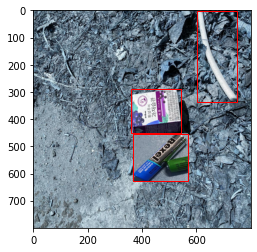

In [91]:
idx=2
output = datasets.prepare_train_img(idx)
image = output['img'].data.permute(1,2,0).detach().numpy()
bboxes = output['gt_bboxes'].data.detach().numpy()
labels = output['gt_labels'].data.detach().numpy()
plt.imshow(image)

ax = plt.gca()

for bbox in bboxes:
    x,y,w,h = bbox[0],bbox[1], bbox[2]-bbox[0],bbox[3]-bbox[1]
    ax.add_patch(
    patches.Rectangle(
        (x,y),w,h,
        fill=False, edgecolor='red'))

print(bboxes)
print(labels)

## label probability settings

In [34]:
 img2idx = { img_id : idx for idx,img_id in enumerate(datasets.img_ids)}
label2anno=[ [] for _ in range(num_classes)]
for idx in datasets.coco.anns.keys():
    label = datasets.coco.anns[idx]['category_id']
    label2anno[label].append(datasets.coco.anns[idx])


instance count : [3205, 4989, 735, 768, 818, 2361, 1010, 4182, 122, 394]


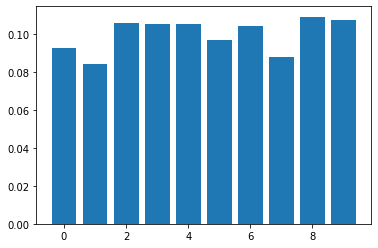

In [63]:
T=1
instance_count = [len(label_count) for label_count in label2anno]
normedWeights = [1 - (x / sum(instance_count)) for x in instance_count]
label_probs = [ np.exp(x*T)/ np.exp(np.array(normedWeights)*T).sum() for x in normedWeights]
print('instance count :',instance_count)
plt.bar(list(range(len(label_probs))),label_probs)
plt.show()